In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [3]:
Image_Width=120
Image_Height=120
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [4]:
filenames=os.listdir("cat vs dog")
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [5]:
df.head()

,filename,category
0,cat.1.jpg,0
1,cat.10.jpg,0
2,cat.100.jpg,0
3,cat.1000.jpg,0
4,cat.1001.jpg,0


In [6]:
df.tail()

,filename,category
8001,dog.996.jpg,1
8002,dog.997.jpg,1
8003,dog.998.jpg,1
8004,dog.999.jpg,1
8005,_DS_Store,0


In [7]:
a=[i for i in df['filename'] if not i.endswith('.jpg')]
a

['_DS_Store']

In [8]:
np.where(df['filename']=='_DS_Store')

(array([8005], dtype=int64),)

In [9]:
df=df.drop(df.index[8005])

In [10]:
df.shape

(8005, 2)

In [11]:
df=df.sample(frac=1,random_state=40)
df.head()

,filename,category
7059,dog.3750.jpg,1
3627,cat.663.jpg,0
6159,dog.2941.jpg,1
341,cat.1305.jpg,0
3705,cat.733.jpg,0


In [12]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization


In [14]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 118, 118, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 118, 118, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 57, 57, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 57, 57, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)       

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [17]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [18]:
total_train,total_validate

(6404, 1601)

In [19]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "cat vs dog",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "cat vs dog", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)


Found 6404 validated image filenames belonging to 2 classes.
Found 1601 validated image filenames belonging to 2 classes.


In [32]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
426/426 [==============================] - 975s 2s/step - loss: 0.9846 - acc: 0.5715 - val_loss: 0.7008 - val_acc: 0.5962
Epoch 2/10
426/426 [==============================] - 863s 2s/step - loss: 0.6664 - acc: 0.6419 - val_loss: 0.8162 - val_acc: 0.6110
Epoch 3/10
426/426 [==============================] - 853s 2s/step - loss: 0.6009 - acc: 0.6897 - val_loss: 0.5932 - val_acc: 0.7062
Epoch 4/10
426/426 [==============================] - 851s 2s/step - loss: 0.5627 - acc: 0.7162 - val_loss: 0.5329 - val_acc: 0.7465
Epoch 5/10
426/426 [==============================] - 859s 2s/step - loss: 0.5510 - acc: 0.7247 - val_loss: 0.5848 - val_acc: 0.6715
Epoch 6/10
426/426 [==============================] - 853s 2s/step - loss: 0.5301 - acc: 0.7411 - val_loss: 0.4679 - val_acc: 0.7844
Epoch 7/10
426/426 [==============================] - 854s 2s/step - loss: 0.5118 - acc: 0.7482 - val_loss: 1.1803 - val_acc: 0.6671
Epoch 8/10
426/426 [==============================] - 846s 2s/step - 

In [71]:
model.save("model_catsVSdogs_10epoch.h5")

In [21]:
from keras.models import load_model
model = load_model('model_catsVSdogs_10epoch.h5')

In [22]:
test_filenames = os.listdir("cat dog test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [23]:
test_df.head()

,filename
0,cat.4001.jpg
1,cat.4002.jpg
2,cat.4003.jpg
3,cat.4004.jpg
4,cat.4005.jpg


In [26]:
test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

test_generator = train_datagen.flow_from_dataframe(test_df,
                                                 "cat dog test",x_col='filename',y_col=None,
                                                 target_size=Image_Size,
                                                 class_mode=None,
                                                 batch_size=batch_size)

Found 2023 validated image filenames.


In [27]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [28]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })


In [32]:
sample_test = test_df.head(18)
sample_test.head()


,filename,category
0,cat.4001.jpg,1
1,cat.4002.jpg,1
2,cat.4003.jpg,0
3,cat.4004.jpg,1
4,cat.4005.jpg,0


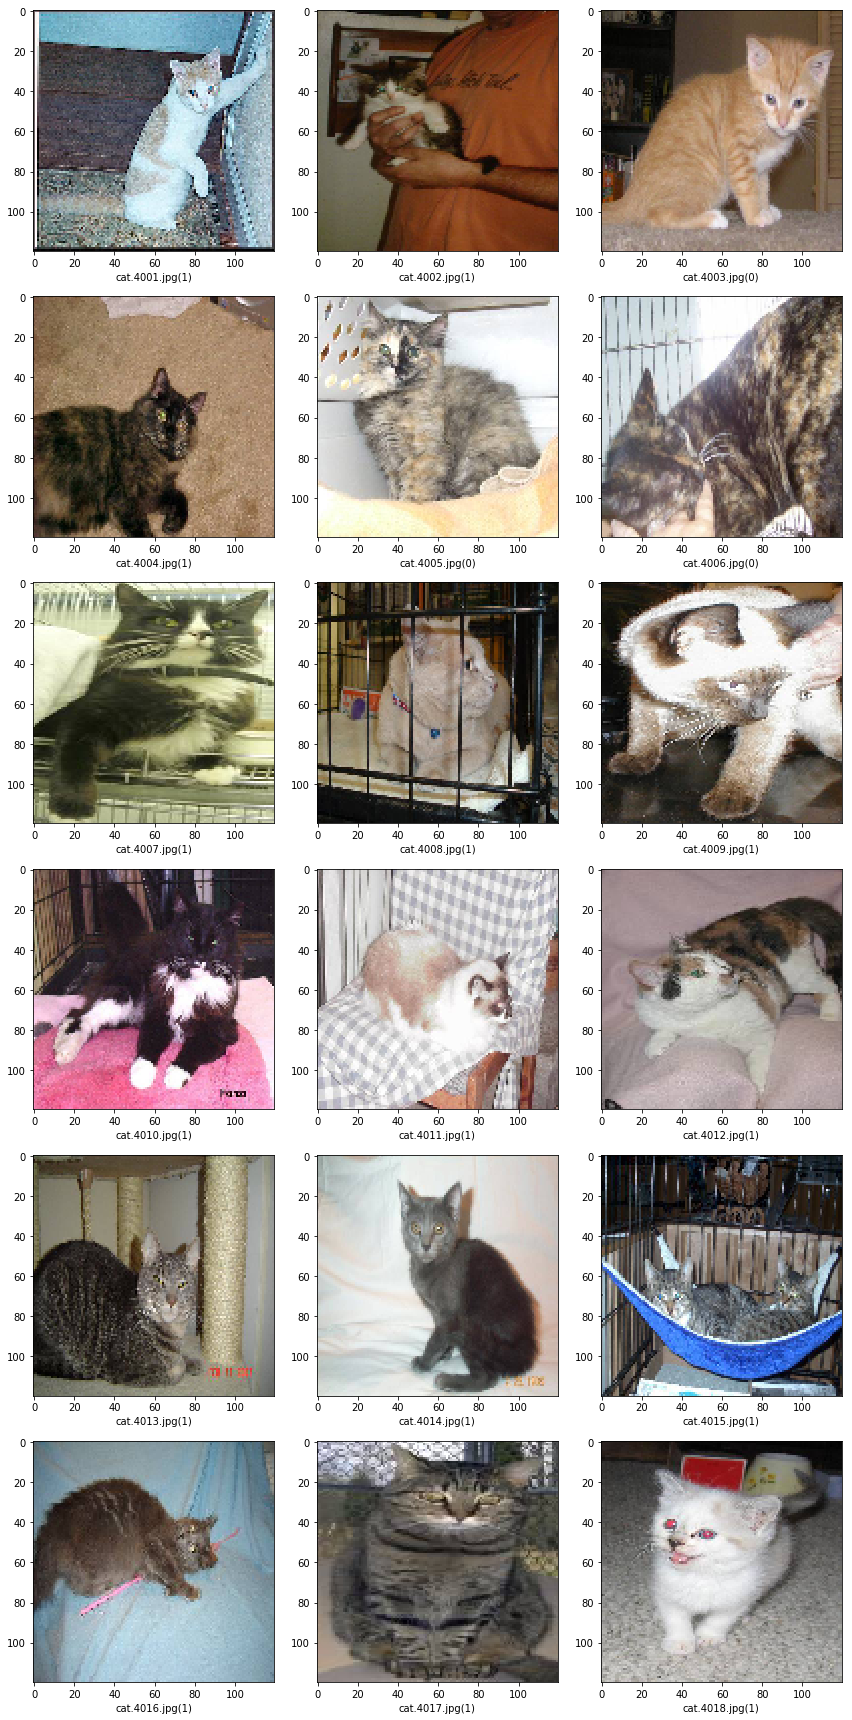

In [41]:
sample_test = test_df.head(18)
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("cat dog test/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [44]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
import numpy as np
im=Image.open("kitty-cat-kitten-pet-45201.jpeg")
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])

0 cat


In [45]:
from PIL import Image
import numpy as np
im=Image.open("photo-1543466835-00a7907e9de1.jpg")
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])

1 dog
